# Hurricane Model Analysis

## Imports, Functions, Paths

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
import sys
import cv2

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from os import path, listdir
from tqdm import tqdm

sys.path.append('..')
from xview2_1st_place_solution.utils import *
from models.hurricane import HurricaneModel

In [17]:
job_id = "3698745"
train_metrics_file = f"hurricane_42_{job_id}_metrics" + ".csv"
checkpoint_file = f"hurricane_42_{job_id}_best"
root = ".."

train_metrics_path = os.path.join(root, "output", "hurricane", train_metrics_file)
weights_path = os.path.join(root, "weights",checkpoint_file)
holdout_path = os.path.join(root, "data_wind", "wind_hold")

In [6]:
def plot_loss_curve(epochs, train_losses, val_losses):
    plt.plot(epochs, train_losses, label='Training')
    plt.plot(epochs, val_losses, label='Validation')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Hurricane Model: Loss Curves")
    plt.legend()
    plt.show()

In [7]:
def validate(net, data_loader, device):
    dices0 = []

    tp = np.zeros((4,))
    fp = np.zeros((4,))
    fn = np.zeros((4,))

    _thr = 0.3

    with torch.no_grad():
        for i, sample in enumerate(tqdm(data_loader)):
            msks = sample["msk"].numpy()
            lbl_msk = sample["lbl_msk"].numpy()
            pre_img = sample["pre_img"].to(device, non_blocking=True)
            post_img = sample["post_img"].to(device, non_blocking=True)
            msks = sample["msk"].numpy()
            out = net(pre_img, post_img)

            msk_pred = torch.sigmoid(out[:, 0, ...]).cpu().numpy() > 0.3
            msk_damage_pred = torch.sigmoid(out).cpu().numpy()[:, 1:, ...]
            
            for j in range(msks.shape[0]):
                dices0.append(dice(msks[j, 0], msk_pred[j] > _thr))

                targ = lbl_msk[j][msks[j, 0] > 0]
                pred = msk_damage_pred[j].argmax(axis=0)
                pred = pred * (msk_pred[j] > _thr)
                pred = pred[msks[j, 0] > 0]
                for c in range(4):
                    tp[c] += np.logical_and(pred == c, targ == c).sum()
                    fn[c] += np.logical_and(pred != c, targ == c).sum()
                    fp[c] += np.logical_and(pred == c, targ != c).sum()

    d0 = np.mean(dices0)

    f1_sc = np.zeros((4,))
    for c in range(4):
        f1_sc[c] = 2 * tp[c] / (2 * tp[c] + fp[c] + fn[c])

    f1 = 4 / np.sum(1.0 / (f1_sc + 1e-6))

    sc = 0.3 * d0 + 0.7 * f1
    print("Val Score: {}, Dice: {}, F1: {}, F1_0: {}, F1_1: {}, F1_2: {}, F1_3: {}".format(sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3]))
    return (sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3])

## Inference

In [8]:
# Create data loader
hold_files = []
for f in sorted(listdir(path.join(holdout_path, 'images'))):
    if '_pre_disaster.png' in f:
        hold_files.append(path.join(holdout_path, 'images', f))

hold_idxs = np.arange(len(hold_files))

class HoldoutData(Dataset):
    def __init__(self, image_idxs):
        super().__init__()
        self.image_idxs = image_idxs

    def __len__(self):
        return len(self.image_idxs)

    def __getitem__(self, idx):
        _idx = self.image_idxs[idx]

        fn = hold_files[_idx]

        img = cv2.imread(fn, cv2.IMREAD_COLOR)
        img2 = cv2.imread(fn.replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_COLOR)

        msk0 = cv2.imread(fn.replace('/images/', '/masks/'), cv2.IMREAD_UNCHANGED)
        lbl_msk1 = cv2.imread(fn.replace('/images/', '/masks/').replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_UNCHANGED)
        msk1 = np.zeros_like(lbl_msk1)
        msk2 = np.zeros_like(lbl_msk1)
        msk3 = np.zeros_like(lbl_msk1)
        msk4 = np.zeros_like(lbl_msk1)
        msk1[lbl_msk1 == 1] = 255
        msk2[lbl_msk1 == 2] = 255
        msk3[lbl_msk1 == 3] = 255
        msk4[lbl_msk1 == 4] = 255

        msk0 = msk0[..., np.newaxis]
        msk1 = msk1[..., np.newaxis]
        msk2 = msk2[..., np.newaxis]
        msk3 = msk3[..., np.newaxis]
        msk4 = msk4[..., np.newaxis]

        msk = np.concatenate([msk0, msk1, msk2, msk3, msk4], axis=2)
        msk = (msk > 127)

        msk = msk * 1

        lbl_msk = msk[..., 1:].argmax(axis=2)
        
        img = preprocess_inputs(img)
        img2 = preprocess_inputs(img2)

        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        img2 = torch.from_numpy(img2.transpose((2, 0, 1))).float()  # Fixed: was using img instead of img2
        msk = torch.from_numpy(msk.transpose((2, 0, 1))).long()

        sample = {'pre_img': img, 'post_img': img2, 'msk': msk, 'lbl_msk': lbl_msk, 'fn': fn}
        return sample

In [ ]:
# Move model to device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Load checkpoint
checkpoint = torch.load(weights_path,
                        map_location=device,
                        weights_only=False)

# Remove 'module.' prefix from state dict keys
state_dict = checkpoint['state_dict']
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        new_state_dict[k[7:]] = v  # Remove 'module.' prefix (7 characters)
    else:
        new_state_dict[k] = v
        
checkpoint_path="../checkpoints/sam_vit_b_01ec64.pth"
model = HurricaneModel(checkpoint_path=checkpoint_path)
model.load_state_dict(new_state_dict)
model.eval()

model.to(device)

# Create DataLoader
inference_data = HoldoutData(hold_idxs)
inference_data_loader = DataLoader(inference_data, 
                                   batch_size=1,
                                   shuffle=False)

# Inference
val_data = validate(model, 
                    data_loader=inference_data_loader,
                    device=device)

Using MPS


100%|██████████| 203/203 [14:39<00:00,  4.33s/it]

Val Score: 0.5248393214034835, Dice: 0.6038298488657758, F1: 0.49098623820535836, F1_0: 0.7210212980677734, F1_1: 0.54036595363341, F1_2: 0.39319549319817315, F1_3: 0.42263608041848927
(np.float64(0.5248393214034835), np.float64(0.6038298488657758), np.float64(0.49098623820535836), np.float64(0.7210212980677734), np.float64(0.54036595363341), np.float64(0.39319549319817315), np.float64(0.42263608041848927))


## Training Metrics

In [37]:
train_df = pd.read_csv(train_metrics_path)

# ['Epoch', 'Train Loss', 'Val Loss', 'Dice', 'F1', 'F1 (None)', 'F1 (Minor)', 'F1 (Major)', 'F1 (Destroyed)', 'Val Score', 'Best Score']


## Plotting

### Loss Curve

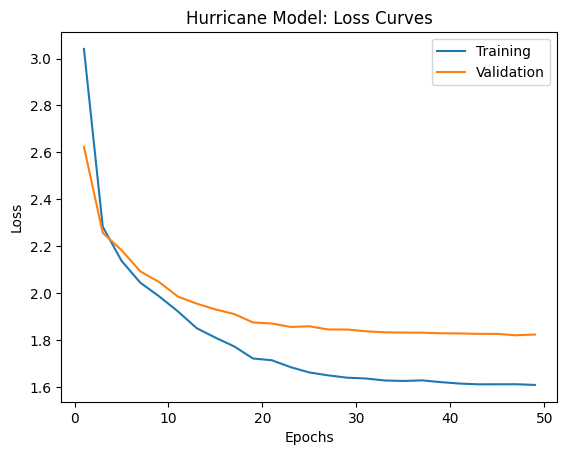

In [38]:
plot_loss_curve(train_df["Epoch"], train_df["Train Loss"], train_df["Val Loss"])

## Metrics